In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import linear_reg_demo_grad_desc
import time

# Linear Regression Redux and Cost

We covered linear regression quite a bit in stats, it is one of the most simple and intuitive methods to make a predictive model - one that most of us did intuitively when doing a best fit line back in math class. 

The linear regression process we looked at used the algorithm of Linear Least Squares, which tries to create a model (the line) that has the lowest average squared distance from all the points. That is, the MSE between the model and the real values is a measurement of "badness" of the model - the smaller this value is, the better the model. We can also think of this MSE calculation as something called a Cost Function - the higher the cost, the worse the model is. 

The fitting part of a linear regression model is an attempt to minimize this cost function. The algorithm looks for the parameters (not hyperparameters) that minimize the cost; in a linear regression those parameters are the coefficients and the y-intercept. 

The linear least sqaures can calculate this directly, so the process of "looking" for the minimum is only one step. If you think back to logistic regression we can see a more dramatic example, the algorithm needs to test, try, and repeat. A decision tree is another example, the gini/entropy is the cost, and the algorithm searches through all potential splits until it finds the one that is best. That type of iteritive process is really common. 

## Cost Functions

The idea of cost is something that we will use throughout machine learning, it is critical for setting a goal that the algorithm can aim for when training. The cost function is just some function that measures the amount of error in a model, the lower the cost, the better a model we have. Usually this cost function is something that is a regular error metric that we have seen before - something like mean squared error for regression problems and accuracy or, more likely, cross-entropy for classifications. The cost to use is often something that we can specify as a hyperparameter when we create our models, such as the choice between gini and entropy in a tree. 

The cost function does not inherently need to be a regular error calculation, it could be almost any calculation at all. In certain weird situations the "goodness" of a model might not be measured accurately by a normal error calculation. Suppose you made a model to predict things on The Price is Right (https://priceisright.fandom.com/wiki/One_Bid); you want the model to make predictions that are close to the real price (probably well measured by MSE), however if the model predicts a price that is over, that's a tragedy and needs to be penalized severely. Maybe you'd want a model that calculated something more odd - MSE if the prediction is less than the real value, and residual^4 if the prediction is higher. 

#### Linear Regression Cost Function

The cost function is just our old friend the Mean Squared Error:

![Linear Regression Cost](images/lin_reg_cost.png "Linear Regression Cost" )

<b>This is critical - the accuracy of our model is defined as some calculation of error (cost), and our model will keep training (updating its parameters) until that calculation of error meets its lowest point (or if it has reached a cut-off).</b>

Generate random data for an example. 

In [2]:
#Generate some random data
X1 = 2 * np.random.rand(1000, 1)
y1 = 4 + 3 * X1**3 + 3*np.random.randn(1000, 1)


Generate a simple linear regression:

<AxesSubplot:xlabel='X', ylabel='Y_pred'>

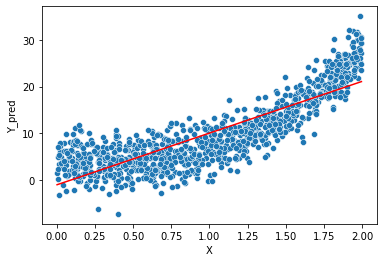

In [3]:
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X1, y1)

preds1 = lin_reg.predict(X1)
d1 = pd.DataFrame(X1, columns={"X"})
d1["Y_pred"] = preds1
d1["Y_real"] = y1
sns.lineplot(data = d1, x="X", y="Y_pred", color="red")
sns.scatterplot(data=d1, x="X", y="Y_real")

#### Regression Results

If we plot some data and generate a regression above, we have a solution that minimizes our cost function. There is no other model that we can create that has a lower mean squared residual between the model's predictions and the real values. Calculating the optimal model like we do here is great, however there are a couple of issues with that:

<ul>
<li>The computation cost when we have lots of data can become very large - growing exponentially. This can really matter when data grows massive. 
<li>Models that are not linear regression often can't be directly calculated (such as logistic regression). This is very common and we'll use gradient descent for things like neural networks later on. 
</ul>

To deal with situations where we can't directly compute the optimal solution we need a different approach. Rather than determining the correct solution directly, we will make an attempt, evaluate the cost, make a slightly different attempt, and try to improve until we can't find a better cost score with subsequent attempts. This approach is called...

## Gradient Descent

Gradient descent is a common approach to hunt for optimal solutions through an iteritive process. The process we can follow is:

<ul>
<li>Make an initial attempt to create a model, calculate the cost. This starting point is often random. 
<li>Compute the gradient - the derivitive or slope of the curve at that point. This indicates which direction to move. 
<li>Adjust the previous attempt, calculate the cost, compare to previous. The adjustment amount is determined by a value called the learning rate. 
<li>Repeat the previous step until moving does not improve the cost.
</ul>

We can visualize this process by looking at a curve of the cost function, and thinking about its derivitive or the slope. The gradient tells us two things:
<ul>
<li>Have we reached the best solution? If so, the gradient will be 0 indicating that we are at the minimum point on the curve. (i.e. there is no slope = we are at the bottom)
<li>Which direction to go? We always want to go down the curve.
</ul>

<b>Note:</b> This is the curve of the <i>cost</i>, not the actual model. The starting amount of error at our first attempt is the starting point, and the bottom of the curve is the lowest amount of error we can achieve. The algorithm is attempting to find the lowest point on the curve.

![Gradient Descent](images/grad_desc.png "Gradient Descent" )

When we've "settled" at the bottom, that is the lowest amount of cost, so there are no moves to make to find a better model. 

### Gradient Descent - From Scratch

We can illustrate how gradient descent works. The file linear_reg_demo_grad_desc.py has an implementation of a linear regression that does gradient descent. I have modified it to return the set of predictions for each step of the training process. So what is happening in the background is:
<ul>
<li>Generate a linear regression. 
<li>Calculate the gradients.
<li>Update the weights to move against the gradient (down the curve).
<ul>
<li>The size of the jump is defined by the learning rate. Big rate, big move!
</ul>
<li> Draw a line on the chart (controled by the num_show varaible). 
<li>Repeat until the trials are done. (In real implementations you'll also stop when improvement ends.)
</ul>

This example is what is called Batch Gradient Descent - at every step the entire process is recalculated. 

Play around with the learning rates and iterations and see how it progresses. The sliders control the settings for the gradient descent, if they aren't working, for whatever reason, just comment out the sliders and set the values directly in the code where shown in the comments. 

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(a, b, c):
    #display(a, b, c)
    return a,b,c
w = interactive(f, a=(0,.1,.01), b=(0,500,10), c=(1,50,1))
display(w)

interactive(children=(FloatSlider(value=0.05, description='a', max=0.1, step=0.01), IntSlider(value=250, descr…

<AxesSubplot:xlabel='X', ylabel='Y_real'>

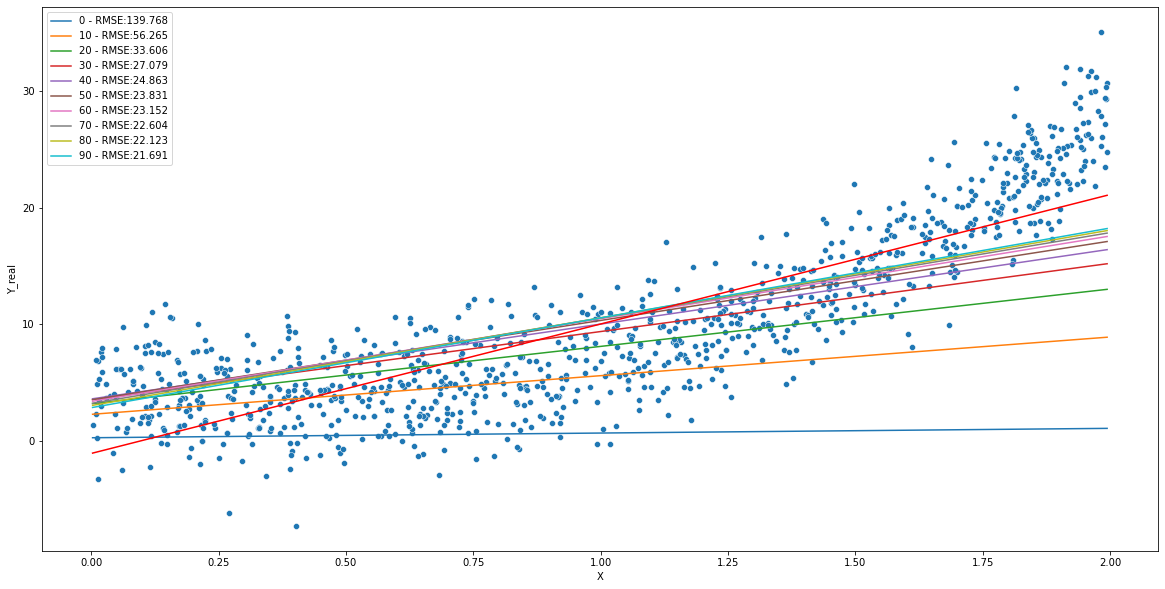

In [22]:
# If this doesn't work, change the commented section to use the preset values and comment out the slider parts. 

#Play around with some options and see the results!
#learn_rate = .03 #Learning rate - how large to move each update.
#iterations = 100 #How many iterations to run. 
#num_show = 10 #How ofen to chart the line, i.e. 1 = every prediction, 10 = every 10th, etc.. 

learn_rate = w.kwargs["a"]
iterations = w.kwargs["b"]
num_show = w.kwargs["c"]


train_rmses = []
test_rmses =[]
iters = []

plt.figure(figsize=(20,10))
X_train, X_test, y_train, y_test = train_test_split(X1, y1)
linreg = linear_reg_demo_grad_desc.LinearRegressionDemo(learning_rate=learn_rate, n_iters=iterations)
preds, test_preds = linreg.fit(X_train, y_train.ravel(), X_test)
sns.scatterplot(data=d1, x="X", y="Y_real")
for i in range(len(preds)):
    d_tmp = pd.DataFrame(X_train, columns={"X"})
    d_tmp["Y_pred"] = preds[i]
    iters.append(i)
    train_err = mean_squared_error(y_train, preds[i])
    train_rmses.append(train_err)
    test_err = mean_squared_error(y_test, test_preds[i])
    test_rmses.append(test_err)
    label = str(i) + " - RMSE:" + str(round(train_err, 3))
    if (i%num_show) == 0:
        sns.lineplot(data = d_tmp, x="X", y="Y_pred", label=label)
d_iters = pd.DataFrame(iters, columns={"Iteration"})
d_iters["Train"] = train_rmses
d_iters["Test"] = test_rmses

sns.lineplot(data = d1, x="X", y="Y_pred", color="red")

### Gradient Descending

The graph above shows the process of gradient descent. The algorithm proceeds by:
<ul>
<li> Generating the first model (line) and calculates the error of that model (RMSE).
    <ul>
    <li> This first try is (effectively) a guess. Real implementations use some logic to try to make the inital guess closer to accurate, but that isn't critical for the process. We just need some starting point.
    </ul>
<li> Calculate the <i><b>gradients</b></i> for the current error. 
    <ul>
    <li> The gradients are the slopes of the error curve at the current point. 
    <li> The gradients tell us which direction to move to improve the error. 
    <li> This is the calculus bit, if we look back to the parabola of error image above, the algorithm calculates the slope of where it is on that error curve and moves towards the bottom. I.e. the slope tells the algorithm to go up or down. 
    </ul>
<li> Increments the parameters (the slope and intercept in this case) either up or down a bit:
    <ul>
    <li> This is the key part of the process - the parameters are the model (think of how in linear regression slope and intercept are all we need to define a model), and here we adjust those parameters to make the model have a little less error - or be better fitted to the data.
    <li> The size of the move is determined by the learning rate parameter.  
    </ul>
<li> Generate another model, calculate the error, and repeat the process. 
<li> When the error can't get lower by changing the parameters anymore (or the limit of trials is hit), finish. Whatever the parameters are at this point are the "answer".
    <ul>
    <li>Recall that the model is just the parameters, for a linear regression if we have the slope(s) and the intercept. For other algorithms the idea is the same, we'd just have different parameters, e.g. for a tree it would be the decision criteria.
    </ul>
</ul>

Each model generated at each step of training works its way bit by bit towards being more accurate. 

### Key Code Bits

We can look at the .py file and examine some of the key bits (you can open it directly for details and full code)

<b>perform gradient descent for n iterations</b>

```python
for _ in range(self.n_iters):
    # get y_prediction
    y_pred = self._get_prediction(X)
    # compute gradients
    dw, db = self._get_gradients(X, y, y_pred)
    # update weights & bias with gradients
    self._update_params(dw, db)
```
Here the fit function is pretty simple, we make a prediction, take that prediction to compute the gradients (slopes), then make and update to the weights...

```python
def _update_params(self, dw, db):
    self.weights -= self.lr * dw
    self.bias -= self.lr * db
```
Updating the weights is just incrementing them by the amount of the learning rate. 

```python
def _get_gradients(self, X, y, y_pred):
    # get distance between y_pred and y_true
    error = y_pred - y
    # compute the gradients of weight & bias
    dw = (1 / self.n_samples) * np.dot(X.T, error)
    db = (1 / self.n_samples) * np.sum(error)
    return dw, db
```
Calculating the gradients is just a recalculation of the gradients at our new point on the cost curve. The math uses vector math (dot products) that we can ignore for now. 

So the overall process, repeated for N iterations is to create a prediction (make a linear regression model), calculate the gradients on the cost curve at that point, update our position based on the position by the amount of the learning rate, and repeat. Eventually we will reach a point where the gradients, the slope of the location on the cost curve, is 0, then we won't be updating anymore - think about why by looking at the _update_params function. 

### Errors by Epoch

We can visualize the errors by iteration, or epoch as it is often called. Here we can see how long it takes for us to narrow in on a solution. 

I've graphed both the test and train errors, here they tend to be extremely close and often flip-flop in terms of accuracy depending on random splits. This is not a constant pattern, it is due to the data. There are a few things that we can watch for in a chart like this, some common ones are:
<ul>
<li> If the testing error starts getting larger again after dropping, that is an indication we may be overfitting. 
<li> If the testing error is never "catching" the tratining error, that is an indication that we may be underfitting. 
</ul>

<AxesSubplot:xlabel='Iteration', ylabel='Train'>

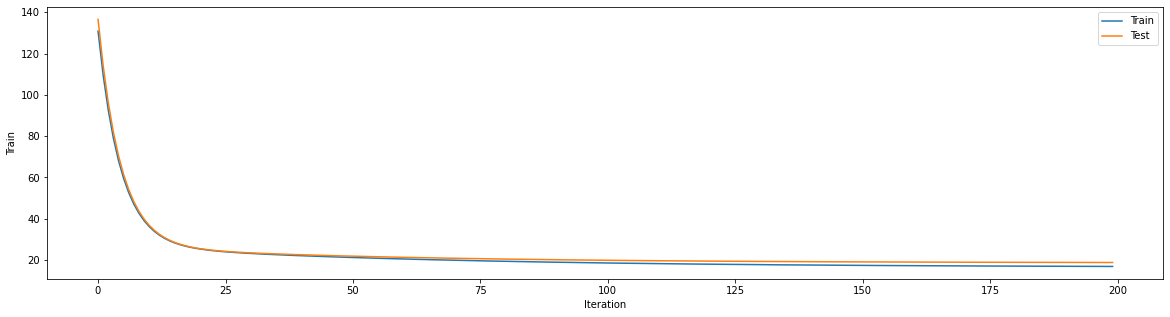

In [18]:
plt.figure(figsize=(20,5))
sns.lineplot(data=d_iters, x="Iteration", y="Train", label="Train")
sns.lineplot(data=d_iters, x="Iteration", y="Test", label="Test")

Our algorithm will work its way towards the solution. 

### Errors and Gradients

For a simple linear regression with one feature like we have here, the challenge is pretty simple. Our cost will be convex (shaped like a bowl), and we will always be able to find some solution, even if it takes a long time. With more complex datasets this isn't always true, we don't have a simple 2D curve, we have something that is in X dimension - maybe 100 or more at times. We can end up with curves that resemble this:

![Complex Gradient Descent](images/comp_grad_desc.png "Complex Gradient Descent" )

Here we have things like a local minima - a point at which the cost is minimized, but only locally, not overall. We don't want the algorithm to get 'stuck' in one of these holes, because we'll find a low cost, but not the lowest. 

Dealing with issues like this is there the learning rate comes in. By ensuring the learning rate is large enough, we have our attempts 'jump around' a little. This results in progress towards the minimum cost that is a little slower, but it also gives the function the ability to 'jump out' of problems like local minima. There's a balance with the learning rate, not too high, not too low. 

## Other Types of Descents

Batch gradient descent, like we did in the demo, suffers from the drawback that there is a lot of math involved in calculating the gradients, each time we make an adjustment to the parameters we have to do many calculations, this can be slow with large amounts of data. In practice, there are a couple of things that we can do to speed this up. 

In the sample each time we iterated we calculated all of those gradients. For simple 2 varible datasets that's no big deal, but when the data gets massive, that's pretty slow. There are other implementations of gradient descent that apply the same concept, but take some shortcuts to lessen the amount of calculations needed. We can visualize how each 'hunts' the solution - the batch descent progresses steadily, the stochastic jumps around semi-randomly, and the mini-batch is between the two:

![Gradient Descent Patterns](images/grad_desc_patterns.png "Gradient Descent Patterns" )

The process of gradient descent can be made faster by taking a shortcut in the calculations - rather than calculating the gradients for each record, we can calculate them for a subset of the records. These methods do the exact same thing and "regular" gradient descent, but when calculating the gradients they use only some of the records rather than all of them.

#### Stochastic Gradient Descent

Stochastic (randomized) Gradient Descent, or SGD, speeds things up by just randomly selecting an instance and using that for the gradient calculation. The speed up comes from that massive reductions in the number of gradients calculated - instead of doing it for each record, SGD does it only once. Much faster. 

The downside to this is that there is much more randomness, and progress towards the solution isn't linear since you might randomly choose a point that is out of the way. This introduces some noise to the process, but the savings in computation time makes it generally worth it. 

#### Mini Batch Gradient Descent

MBGD combines the ideas of batch and SGD - at each step a small random subset of the data is used for the gradient calculations. 

#### Gradients and Outcomes

Note that the idea of all these algoritms is to generate a final model that is nearly the same, only the path there is different. Gradient descent isn't attempting to find a better model than linear regression (in a regular linear regression we can calculate the best model in a closed for solution), it is attempting to use a different method to reach that goal model. This idea of "narrowing in" on a solution can become even more useful when we don't have a solution that can be directly calculated - as long as we can set the cost function that defines accuracy, we can work our way towards an optimal solution. 

In general, the fewer records we use in calculating the gradient descent, the more randomized the progress towards the solution will be. This makes sense, as any one record in the data could be anything, so our progress can jump around more. 

<b>Note:</b> for this chart, m = number of rows, n = number of features. 

![Gradient Descent Outcomes](images/grad_desc_usage.png "Gradient Descent Outcomes" )

### SGD in Practice

We thankfully do not need to implement this descent process by hand in practice, we can use the built in SKlearn modules, and the idea is also built into several other algorithms. For linear regression we can use SGDregressor, a generic implementation of SGD.


We can do some gradient descent with actual data. 

In [7]:
df = pd.read_csv("data/bodyfat.csv")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Density,252.0,1.055574,0.019031,0.995,1.0414,1.0549,1.0704,1.1089
BodyFat,252.0,19.150794,8.368740,0.000,12.4750,19.2000,25.3000,47.5000
Age,252.0,44.884921,12.602040,22.000,35.7500,43.0000,54.0000,81.0000
Weight,252.0,178.924405,29.389160,118.500,159.0000,176.5000,197.0000,363.1500
Height,252.0,70.148810,3.662856,29.500,68.2500,70.0000,72.2500,77.7500
Neck,252.0,37.992063,2.430913,31.100,36.4000,38.0000,39.4250,51.2000
Chest,252.0,100.824206,8.430476,79.300,94.3500,99.6500,105.3750,136.2000
Abdomen,252.0,92.555952,10.783077,69.400,84.5750,90.9500,99.3250,148.1000
Hip,252.0,99.904762,7.164058,85.000,95.5000,99.3000,103.5250,147.7000
Thigh,252.0,59.405952,5.249952,47.200,56.0000,59.0000,62.3500,87.3000


In [8]:
#Create Datasets
y2 = np.array(df["BodyFat"]).reshape(-1,1)
X2 = np.array(df.drop(columns={"BodyFat"}))
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.3)

### Linear Regression Control Sample

We can generate a standard linear regression model first, and see what the results are. 

In [9]:
#Closed Form Linear Regression
pipe_LR_steps = [('scale', MinMaxScaler()), ('model', LinearRegression())]
pipe_LR = Pipeline(pipe_LR_steps)

start = time.process_time()
pipe_LR.fit(X_train2, y_train2)
print(time.process_time() - start)

print('Training CrossVal Score:', cross_val_score(pipe_LR, X_train2, y_train2, cv=5))
print('Testing score:', pipe_LR.score(X_test2, y_test2))


0.0
Training CrossVal Score: [0.86593616 0.99047951 0.99512247 0.98137308 0.98652146]
Testing score: 0.9746003815606854


### SGD Regression

Now we can create a model using gradient descent. There are a few options that we can specify in the SGD that are important:
<ul>
<li>eta0 - the initial learning rate. 
<li>learning_rate - how the learning rate is managed. In the examples we made by hand, the learning rate was constant. The SGD implementation provides for a way to adapt the learning rate - as you get closer to a solution, the learning rate slows. The defult is "invscaling", defined as: eta = eta0 / pow(t, power_t). 
    <ul>
    <li> t = number of updates.
    <li> power_t = the exponent for inverse scaling learning rate.
    <li>This has the effect of using large learning rates to quickly narrow down to a close solution, hopefully taking advantage of both that speed increase and the ability to "jump" out of local minima. As the algorithm progresses, the rate slows to close in directly on a solution. 
    </ul>
<li>early_stopping - should the algorithm stop when it fails to improve. This will set aside a validation dataset, and if predictions for this set stop improving, end the training. If we look back to the demo, at some point the error flattens out and doesn't change much, early stopping stops at this point. We'll look at early stopping in more detail later on. 
<li>penalty - SGD applies regularization by default, which we'll discuss next time.
</ul>

<b>Note: Scaling values is very important in SGD algorithms. We'll probably get poor results if we forget.</b>

In [10]:
#SGD Regressor. 
pipe_SGD_steps = [('scale', MinMaxScaler()), ('model', SGDRegressor(max_iter=10000, eta0=.1))]
pipe_SGD = Pipeline(pipe_SGD_steps)

start = time.process_time()
pipe_SGD.fit(X_train2, y_train2.ravel())
print(time.process_time() - start)

#Print best model and test score
print('Training CrossVal Score:', cross_val_score(pipe_SGD, X_train2, y_train2.ravel(), cv=5))
print('Testing score:', pipe_SGD.score(X_test2, y_test2))

0.03125
Training CrossVal Score: [0.89499265 0.9577519  0.96429935 0.94458106 0.97224447]
Testing score: 0.9628239223642497


Play around with the learning rate and see what impact it has on the speed of SGD as compared to regular linear regression. 

<b>Note:</b> for regression, the cross validation score is the R^2 value.

### Gradient Descent in General

When doing a linear regression, gradient descent isn't really <i>needed</i> because we can calculate a closed form solution, such as the linear least squares calculation. In other models, this isn't true - we start with an initial guess and have to use gradient descent to find the best solution. This is true with logistic regression, these implementations of linear regression, neural networks, and many other models.

We'll spend more time on the inners workings of gradient descent when we get to neural networks - those types of models commonly do many rounds of training to get to an accurate model, often with massive datasets, and the gradient descent is a key part of that process.

Next week we'll look at the next step in the process - regularization. Regularization is another way to improve the fit of our models, largely again by limiting overfitting. Regularization does its work by changing the way the cost funtion... functions, so the gradient descent process itself is manipulated to help us get a better model.

## Exercise

Predict the price. 

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [12]:
df_ex = pd.read_csv("data/house_data.csv")
df_ex.drop(columns={"lat","long","zipcode"}, inplace=True)
df_ex.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503


Data preview - we don't have missing values, but we do have some things to address. There looks to be some, at least partially, redundant variables - largely related to size. There are also some numeric measures that may actually be better as categorical variables.There are also a few things for spatial location that we can probably drop (I did it above). Also, I'll do some basic outlier filters. 

I'll try first with a simple model without much preprocessing. 

##### More Data Prep 

Try with some data transformations:
<ul>
<li> Make renovated into a boolean.
<li> Make has a basement into a boolean.
<li> Change yr_built to age. 
<li> Treat condition and grade as categorical variables.
<li> Remove some redundant variables relating to size. 
<li> Treat floors as categorical.
</ul>

Will these work? We don't know - based on some domain knowledge (what we know about the housing market) these are reasonable steps that will make the data needed for our predictions slightly more simple, and might improve things... but we don't know.

Results... overall changes look good. The scores are slightly better, our model is smaller and simpler, we've removed some of the multicollinearity, and we've made the data easier to interpret.

## Exercise

Predict car prices using an SGD Regressor. 

In [13]:
df3 = pd.read_csv("data/CarPrice_Assignment.csv")
df3.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


<b>Note: There is probably a large amount of multicollinearity here. We'll try this example again with regularization soon, which is one way to deal with it in practice. For now, I won't address it, for simplicity. In general, we won't do every single thing that might be useful for every single example, it would just take too much time and space. That doesn't mean those things aren't relevant, we want to keep them for "real" applications.</b>

First, Import some useful libraries for the preparation pipeline. 

I'm going to use a column transformer to handle the categorical variables separately from the numeric ones. For the numeric variables I'm going to use a simple imputer (though we can see that there are no missing values, just for fun!) as well as a scaler since the features have different ranges. For the categorical variables I'm going to use a one hot encoder to create dummy variables.

<b>Note:</b> Depending on randomness there may be a need to deal with rare categorical values. Keep this in mind, you should be able to find 2+ solutions by Googling the error. 

Assemble the data pipeline.